<a href="https://colab.research.google.com/github/call493/MLFC/blob/main/_notebooks/Poverty_and_Literacy_levels_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the link between literacy rates and poverty in Kenya - A Soci-Economic Analysis



---



Braxton Mandara, DSAIL

15-09-2025

# **OSMnx Setup**

Installing Python packages which we will use to download, model and analyze map features and other spatial data from OpenStreetMap.*italicized text*



In [19]:
%%capture
%pip install osmnx

In [20]:
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

Downloading data for Kenya

In [ ]:
place_name = "Nyeri, Kenya"
latitude = -0.4371
longitude = 36.9580
placestub = place_name.lower().replace(' ', '-').replace(',','')

Bounding box for Kenya:
Min Longitude (minx): 33.9096888
Min Latitude (miny): -4.8995204
Max Longitude (maxx): 41.9067502
Max Latitude (maxy): 4.62


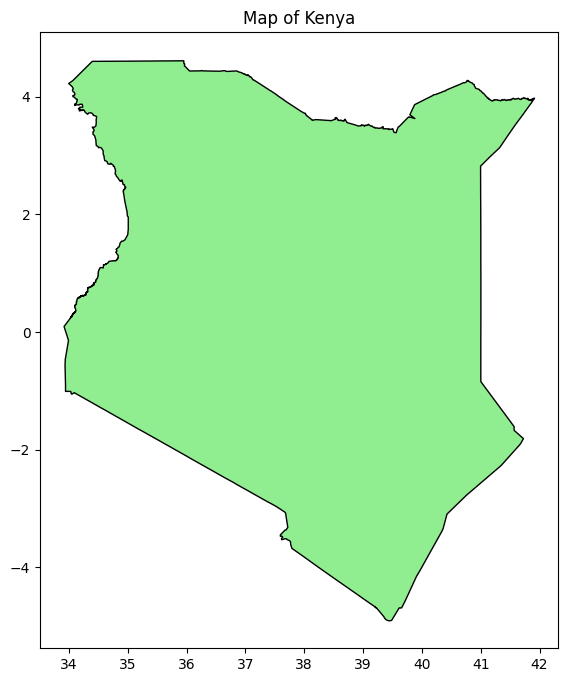

In [21]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the place name
place_name = "Kenya"

# Download the boundary polygon for Kenya
boundary = ox.geocode_to_gdf(place_name)

# Extract the bounding box coordinates
minx, miny, maxx, maxy = boundary.total_bounds

print(f"Bounding box for Kenya:")
print(f"Min Longitude (minx): {minx}")
print(f"Min Latitude (miny): {miny}")
print(f"Max Longitude (maxx): {maxx}")
print(f"Max Latitude (maxy): {maxy}")

# Plot the map of Kenya
fig, ax = plt.subplots(figsize=(8, 8))
boundary.plot(ax=ax, color='lightgreen', edgecolor='black')
ax.set_title('Map of Kenya')
plt.show()

Show Counties and road networks in Kenya

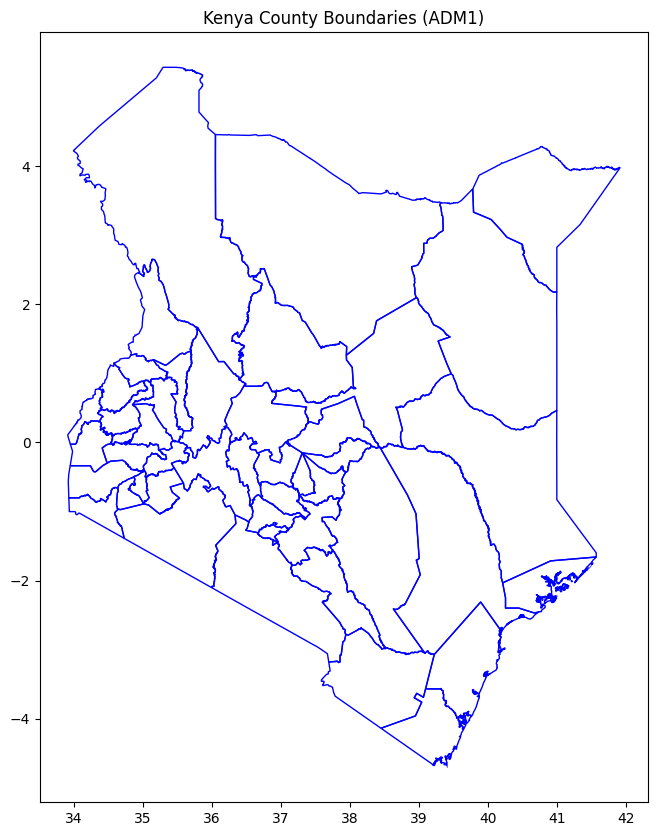

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt

# URL to the GeoJSON file for Kenyan counties (ADM1) from GeoBoundaries
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"

# Load GeoJSON data into a GeoDataFrame
gdf = gpd.read_file(geojson_url)

# Plot the boundaries
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

ax.set_title("Kenya County Boundaries (ADM1)")

plt.show()

Print location of schools on the map

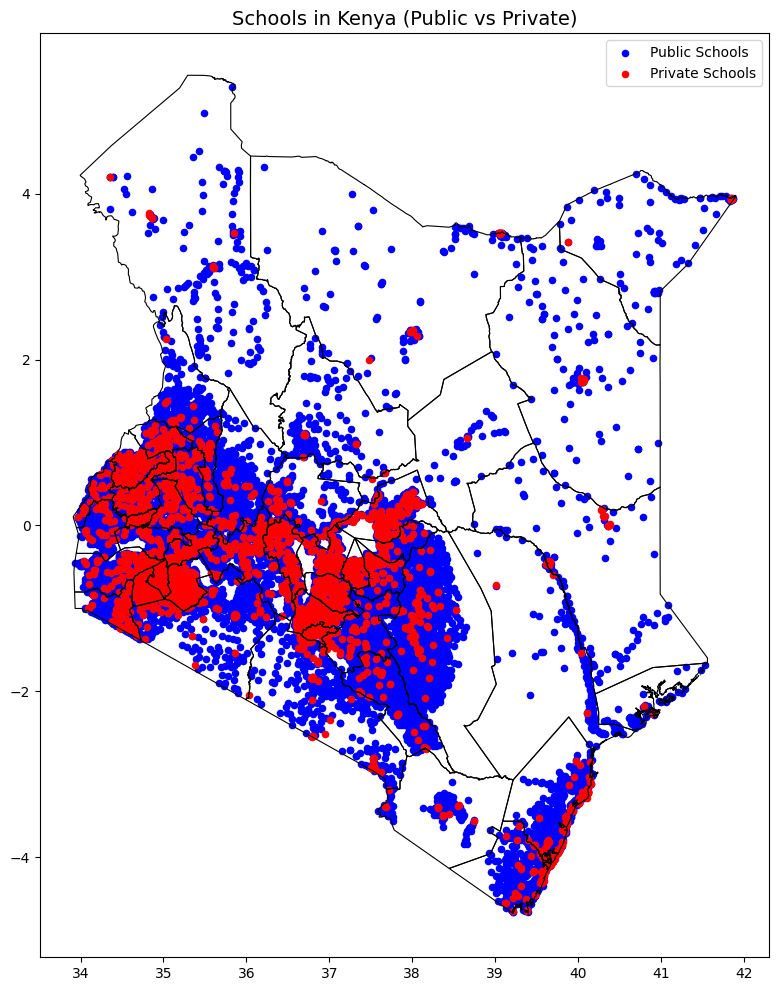

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Path to your local schools.json file
schools_file = "https://raw.githubusercontent.com/call493/MLFC/main/schools.json"

# URL to the GeoJSON file for Kenyan counties (ADM1)
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"

# Load Kenya county boundaries
kenya_gdf = gpd.read_file(geojson_url)

# Load schools data from local machine
schools_gdf = gpd.read_file(schools_file)

# Reproject schools to match counties
schools_gdf = schools_gdf.to_crs(kenya_gdf.crs)

# Separate public and private schools
public_schools = schools_gdf[schools_gdf["Status"] == "Public"]
private_schools = schools_gdf[schools_gdf["Status"] == "Private"]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
kenya_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)

# Plot schools
public_schools.plot(ax=ax, color="blue", markersize=20, label="Public Schools")
private_schools.plot(ax=ax, color="red", markersize=20, label="Private Schools")

ax.set_title("Schools in Kenya (Public vs Private)", fontsize=14)
ax.legend()

plt.show()

### Obtain and Prepare Population Data

The Kenya National Bureau of Statistics (KNBS) provides population data. I will search for the 2019 Census data which includes population counts by county. I will use the data from the following source:

[https://www.knbs.or.ke/](https://www.knbs.or.ke/){: .external}

Specifically, the 2019 Kenya Population and Housing Census results. I will look for data at the county level.

In [24]:
import pandas as pd
import os

# Define the path to the uploaded CSV file
population_file_url = "https://raw.githubusercontent.com/call493/MLFC/main/kenya_population_by_county_2019.csv"

try:
    population_df = pd.read_csv(population_file_url)
    print("Population data loaded successfully!")
    display(population_df.tail())
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

Population data loaded successfully!


,County,Male,Female,Intersex,Total
42,Homa Bay,539560,592367,23,1131950
43,Migori,536187,580214,35,1116436
44,Kisii,605784,661038,38,1266860
45,Nyamira,290907,314656,13,605576
46,Nairobi City,2192452,2204376,245,4397073


### Merge Population Data with County Boundaries

Now, I will merge the population data with the county boundaries GeoDataFrame. I will use the 'County' column in the population DataFrame and the 'ADM1NAME' column in the county GeoDataFrame as the common key for merging. I will perform a left merge to keep all the county geometries and add the population data where a match is found.

In [25]:
# Rename the 'County' column in population_df to match the county names in kenya_gdf for merging
# You might need to inspect both DataFrames to confirm the correct column names and potentially clean them
# For this example, I'll assume the county names in both DataFrames can be matched directly or with minor adjustments.

# It's important to check if the county names match exactly in both dataframes.
# Let's print the unique county names from both dataframes to compare.
print("Unique counties in population_df:")
print(population_df['County'].unique())

print("\nColumns in kenya_gdf:")
print(kenya_gdf.columns)

# Assuming the county names match or can be easily mapped, proceed with the merge
# If names don't match, further data cleaning or mapping would be required.
# For now, let's assume 'County' in population_df corresponds to 'ADM1NAME' in kenya_gdf

# Perform the merge
# kenya_population_gdf = kenya_gdf.merge(population_df, left_on='ADM1NAME', right_on='County', how='left')

# Drop the redundant 'County' column from the merged GeoDataFrame
# kenya_population_gdf = kenya_population_gdf.drop('County', axis=1)

# print("\nMerged GeoDataFrame with population data:")
# display(kenya_population_gdf.head())

Unique counties in population_df:
['Mombasa' 'Kwale' 'Kilifi' 'Tana River' 'Lamu' 'Taita/Taveta' 'Garissa'
 'Wajir' 'Mandera' 'Marsabit' 'Isiolo' 'Meru' 'Tharaka-Nithi' 'Embu'
 'Kitui' 'Machakos' 'Makueni' 'Nyandarua' 'Nyeri' 'Kirinyaga' "Murang'a"
 'Kiambu' 'Turkana' 'West Pokot' 'Samburu' 'Trans Nzoia' 'Uasin Gishu'
 'Elgeyo/Marakwet' 'Nandi' 'Baringo' 'Laikipia' 'Nakuru' 'Narok' 'Kajiado'
 'Kericho' 'Bomet' 'Kakamega' 'Vihiga' 'Bungoma' 'Busia' 'Siaya' 'Kisumu'
 'Homa Bay' 'Migori' 'Kisii' 'Nyamira' 'Nairobi City']

Columns in kenya_gdf:
Index(['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType',
       'geometry'],
      dtype='object')


### Population Heatmap by County

This heatmap visualizes the population distribution across Kenyan counties based on the 2019 census data. Counties with higher populations are shown in darker shades, while those with lower populations are in lighter shades.

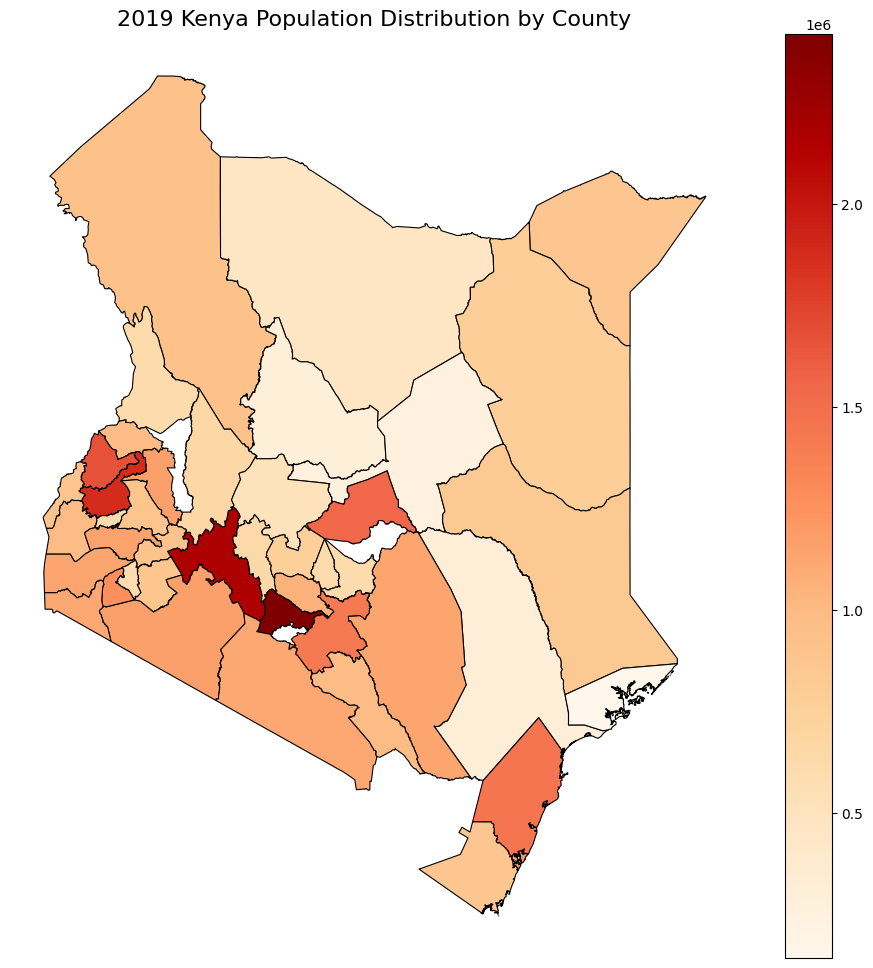

In [26]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Load Kenya county boundaries (from geoBoundaries)
# -----------------------------
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"
kenya_gdf = gpd.read_file(geojson_url)

# -----------------------------
# Load population data (CSV we created earlier)
# -----------------------------

# Normalize county names for matching
population_df["County"] = population_df["County"].str.strip().str.upper()
kenya_gdf["shapeName"] = kenya_gdf["shapeName"].str.strip().str.upper()

# -----------------------------
# Merge population with county boundaries
# -----------------------------
merged = kenya_gdf.merge(population_df, left_on="shapeName", right_on="County", how="left")

# -----------------------------
# Plot heatmap
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 12))
merged.plot(
    column="Total",          # population column
    cmap="OrRd",             # color scheme (Orange-Red)
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("2019 Kenya Population Distribution by County", fontsize=16)
ax.axis("off")

plt.show()


In [27]:
# 1. Normalize county names
population_df["County"] = (
    population_df["County"]
    .str.strip()
    .str.upper()
    .str.replace("-", " ")
    .str.replace("/", " ")
    .str.replace(" CITY", "", regex=False)   # remove CITY suffix
)

kenya_gdf["shapeName"] = kenya_gdf["shapeName"].str.strip().str.upper()

# 2. Special manual fixes
name_corrections = {
    "THARAKA NITHI": "THARAKA",   # shapefile uses THARAKA
}
population_df["County"] = population_df["County"].replace(name_corrections)

# 3. Merge again
merged = kenya_gdf.merge(
    population_df,
    left_on="shapeName",
    right_on="County",
    how="left"
)

# 4. Check for missing counties again
missing = merged[merged["Total"].isna()][["shapeName"]]
print("Counties with no population data:\n", missing)


Counties with no population data:
          shapeName
8  ELGEYO-MARAKWET


In [28]:
name_corrections = {
    "ELGEYO MARAKWET": "ELGEYO-MARAKWET"
}
population_df["County"] = population_df["County"].replace(name_corrections)


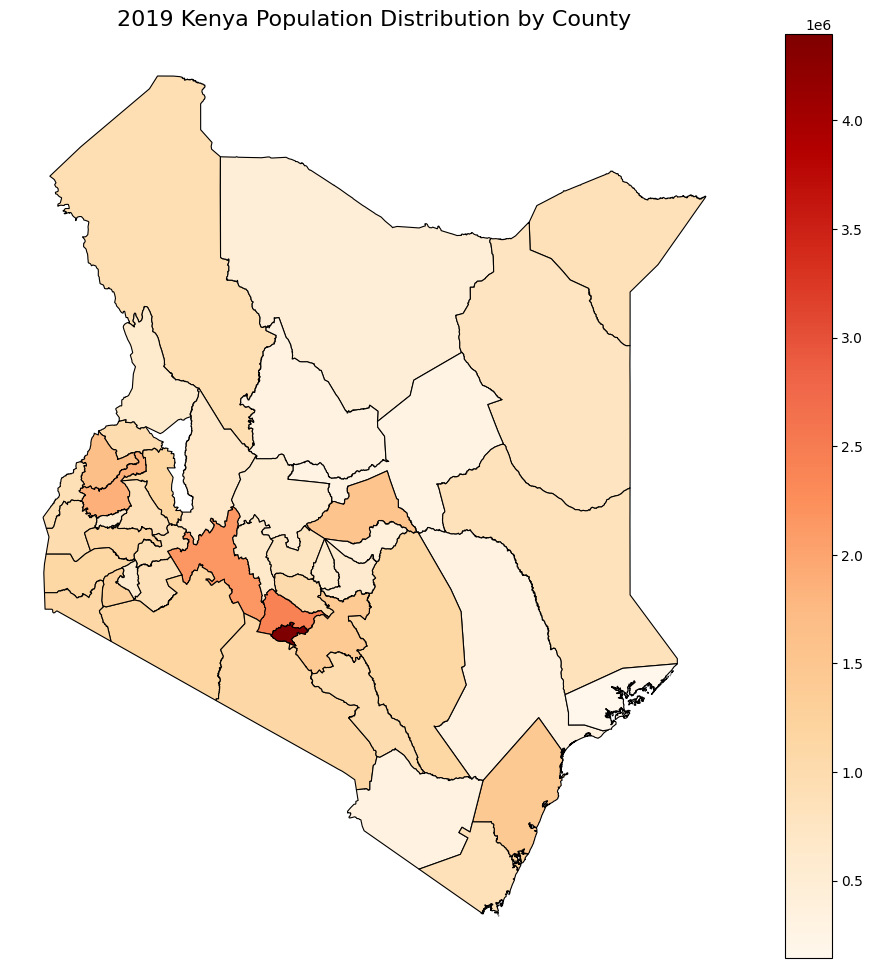

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
merged.plot(
    column="Total",          # population column
    cmap="OrRd",             # color scheme (Orange-Red)
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("2019 Kenya Population Distribution by County", fontsize=16)
ax.axis("off")

plt.show()

### Combined Map: Population Heatmap and Schools

This map visualizes the population distribution across Kenyan counties as a heatmap, along with the locations of public and private schools.

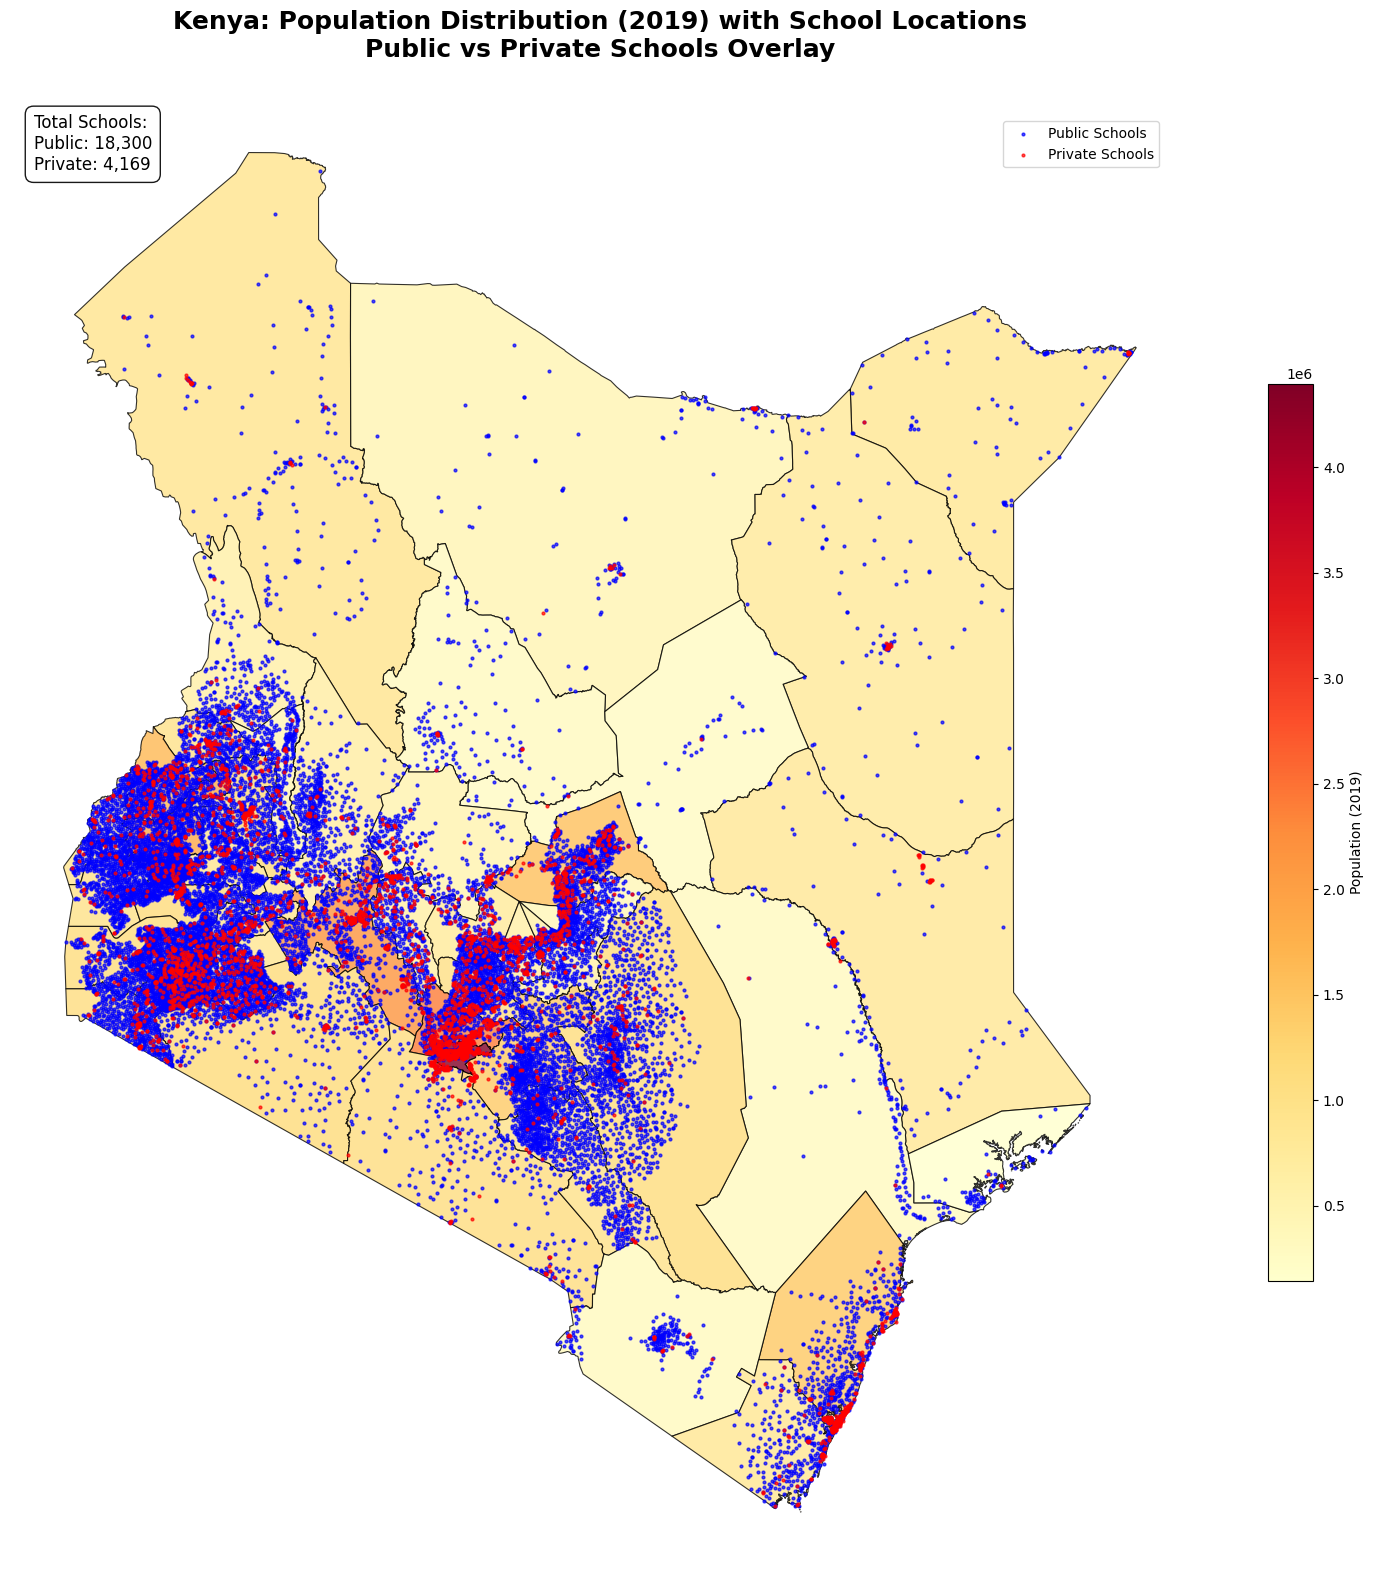


=== COMBINED HEATMAP SUMMARY ===
Total counties visualized: 47
Public schools plotted: 18,300
Private schools plotted: 4,169
Total schools: 22,469
Total population (2019): 47,564,296
Average population per county: 1,012,006


In [32]:
# Combined Map: Population Heatmap with Schools Overlay
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load data
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"
kenya_gdf = gpd.read_file(geojson_url)

population_file_url = "https://raw.githubusercontent.com/call493/MLFC/main/kenya_population_by_county_2019.csv"
population_df = pd.read_csv(population_file_url)

schools_file = "https://raw.githubusercontent.com/call493/MLFC/main/schools.json"
schools_gdf = gpd.read_file(schools_file)

# Data preprocessing
population_df["County"] = (population_df["County"].str.strip().str.upper().str.replace("-", " ").str.replace("/", " ").str.replace(" CITY", "", regex=False))
kenya_gdf["shapeName"] = kenya_gdf["shapeName"].str.strip().str.upper()

name_corrections = {"THARAKA NITHI": "THARAKA", "ELGEYO MARAKWET": "ELGEYO-MARAKWET"}
population_df["County"] = population_df["County"].replace(name_corrections)

merged = kenya_gdf.merge(population_df, left_on="shapeName", right_on="County", how="left")

schools_gdf = schools_gdf.to_crs(kenya_gdf.crs)
public_schools = schools_gdf[schools_gdf["Status"] == "Public"]
private_schools = schools_gdf[schools_gdf["Status"] == "Private"]

# Create combined plot
fig, ax = plt.subplots(figsize=(16, 16))

# Plot population heatmap
merged.plot(
    column="Total",
    cmap="YlOrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    alpha=0.8,
    legend_kwds={'label': "Population (2019)", 'orientation': "vertical", 'shrink': 0.6}
)

# Overlay schools
public_schools.plot(ax=ax, color="blue", markersize=4, label="Public Schools", alpha=0.7)
private_schools.plot(ax=ax, color="red", markersize=4, label="Private Schools", alpha=0.7)

# Customize plot
ax.set_title(
    "Kenya: Population Distribution (2019) with School Locations\nPublic vs Private Schools Overlay",
    fontsize=18, fontweight='bold', pad=20
)
ax.axis("off")
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))

# Add statistics box
total_public = len(public_schools)
total_private = len(private_schools)
stats_text = f"Total Schools:\nPublic: {total_public:,}\nPrivate: {total_private:,}"
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== COMBINED HEATMAP SUMMARY ===")
print(f"Total counties visualized: {len(merged)}")
print(f"Public schools plotted: {total_public:,}")
print(f"Private schools plotted: {total_private:,}")
print(f"Total schools: {total_public + total_private:,}")
print(f"Total population (2019): {merged['Total'].sum():,.0f}")
print(f"Average population per county: {merged['Total'].mean():,.0f}")


## Poverty Data Integration and Analysis

The next step in our socio-economic analysis is to incorporate poverty rate data by county. This will allow us to:

1. **Import county-level poverty data** from a CSV source
2. **Merge poverty rates** with our existing population and geographic data
3. **Visualize the relationship** between poverty rates, population density, and educational infrastructure
4. **Analyze spatial patterns** to identify areas with high poverty and limited school access

We will create a comprehensive map showing poverty rates as a heatmap with school locations overlaid as points, enabling us to examine the correlation between poverty levels and educational infrastructure distribution across Kenya.

In [ ]:
# 1. Import and load the poverty data (replace URL with your actual data source if needed)
poverty_file_url = "https://raw.githubusercontent.com/call493/MLFC/main/kenya_poverty_by_county.csv"  # Example path
poverty_df = pd.read_csv(poverty_file_url)
print("Poverty data sample:")
display(poverty_df.head())

# 2. Standardize county names for joining
poverty_df['County'] = poverty_df['County'].str.strip().str.upper()

# 3. Merge with existing merged GeoDataFrame (called 'merged')
merged_pov = merged.merge(poverty_df, left_on='shapeName', right_on='County', how='left')

# 4. Plot poverty rate map with school locations
fig, ax = plt.subplots(figsize=(14, 14))
merged_pov.plot(
    column="Poverty_Rate", cmap="YlGnBu", linewidth=0.8, edgecolor="black",
    legend=True, ax=ax, alpha=0.7
)
public_schools.plot(ax=ax, color="blue", markersize=20, label="Public Schools", alpha=0.6)
private_schools.plot(ax=ax, color="red", markersize=20, label="Private Schools", alpha=0.6)

ax.set_title("Poverty Rate by County with School Locations in Kenya", fontsize=16)
ax.axis("off")
ax.legend()
plt.show()


## Merging County Poverty Data and Mapping Poverty-Education Relationships

We will now integrate county-level poverty data to examine the relationship between poverty rates and educational infrastructure distribution across Kenya. This analysis will:

1. **Load poverty rate data** from our CSV file containing county-level poverty statistics
2. **Clean and normalize county names** to ensure proper matching with our existing merged dataset
3. **Merge poverty data** with our existing population and geographic data
4. **Create a comprehensive visualization** showing poverty rates as a heatmap with school locations overlaid

This will enable us to identify spatial patterns and correlations between areas of high poverty and the availability of educational infrastructure, providing insights into educational equity across Kenya's counties.

In [34]:
# 1. Load the county poverty rate data
poverty_file_url = "https://raw.githubusercontent.com/call493/MLFC/main/county_poverty_rates20056.csv"
poverty_df = pd.read_csv(poverty_file_url)
print("Columns in poverty_df:", poverty_df.columns.tolist())
display(poverty_df.head())

# 2. Standardize county names for accurate joining
poverty_df['County'] = poverty_df['County'].str.strip().str.upper()

# 3. Merge with your 'merged' GeoDataFrame on county name
merged_pov = merged.merge(poverty_df, left_on="shapeName", right_on="County", how="left")

# 4. Identify the poverty rate column (adjust if column name differs)
poverty_col = 'PovertyRate'  # CHANGE this if the printed columns show a different name

# 5. Plot the poverty rate heatmap with schools as points
fig, ax = plt.subplots(figsize=(14, 14))
merged_pov.plot(
    column=poverty_col, cmap="YlOrRd", linewidth=0.8, edgecolor="black", legend=True, ax=ax, alpha=0.7
)
public_schools.plot(ax=ax, color="blue", markersize=20, label="Public Schools", alpha=0.6)
private_schools.plot(ax=ax, color="red", markersize=20, label="Private Schools", alpha=0.6)
ax.set_title("Poverty Rate by County with Schools in Kenya")
ax.axis("off")
ax.legend()
plt.show()


Columns in poverty_df: ['objectid', 'county', 'number_of_poor_individuals_2005', 'poverty_rate__percentage_']


,objectid,county,number_of_poor_individuals_2005,poverty_rate__percentage_
0,1,BARINGO,330222,58.5
1,2,BOMET,341053,50.7
2,3,BUNGOMA,737571,52.2
3,4,BUSIA,518951,66.0
4,5,EMBU,205282,55.2


KeyError: 'County'

Columns in poverty_df: ['objectid', 'county', 'number_of_poor_individuals_2005', 'poverty_rate__percentage_']


,objectid,county,number_of_poor_individuals_2005,poverty_rate__percentage_
0,1,BARINGO,330222,58.5
1,2,BOMET,341053,50.7
2,3,BUNGOMA,737571,52.2
3,4,BUSIA,518951,66.0
4,5,EMBU,205282,55.2



Successfully merged 47 rows
Non-null poverty rates: 40


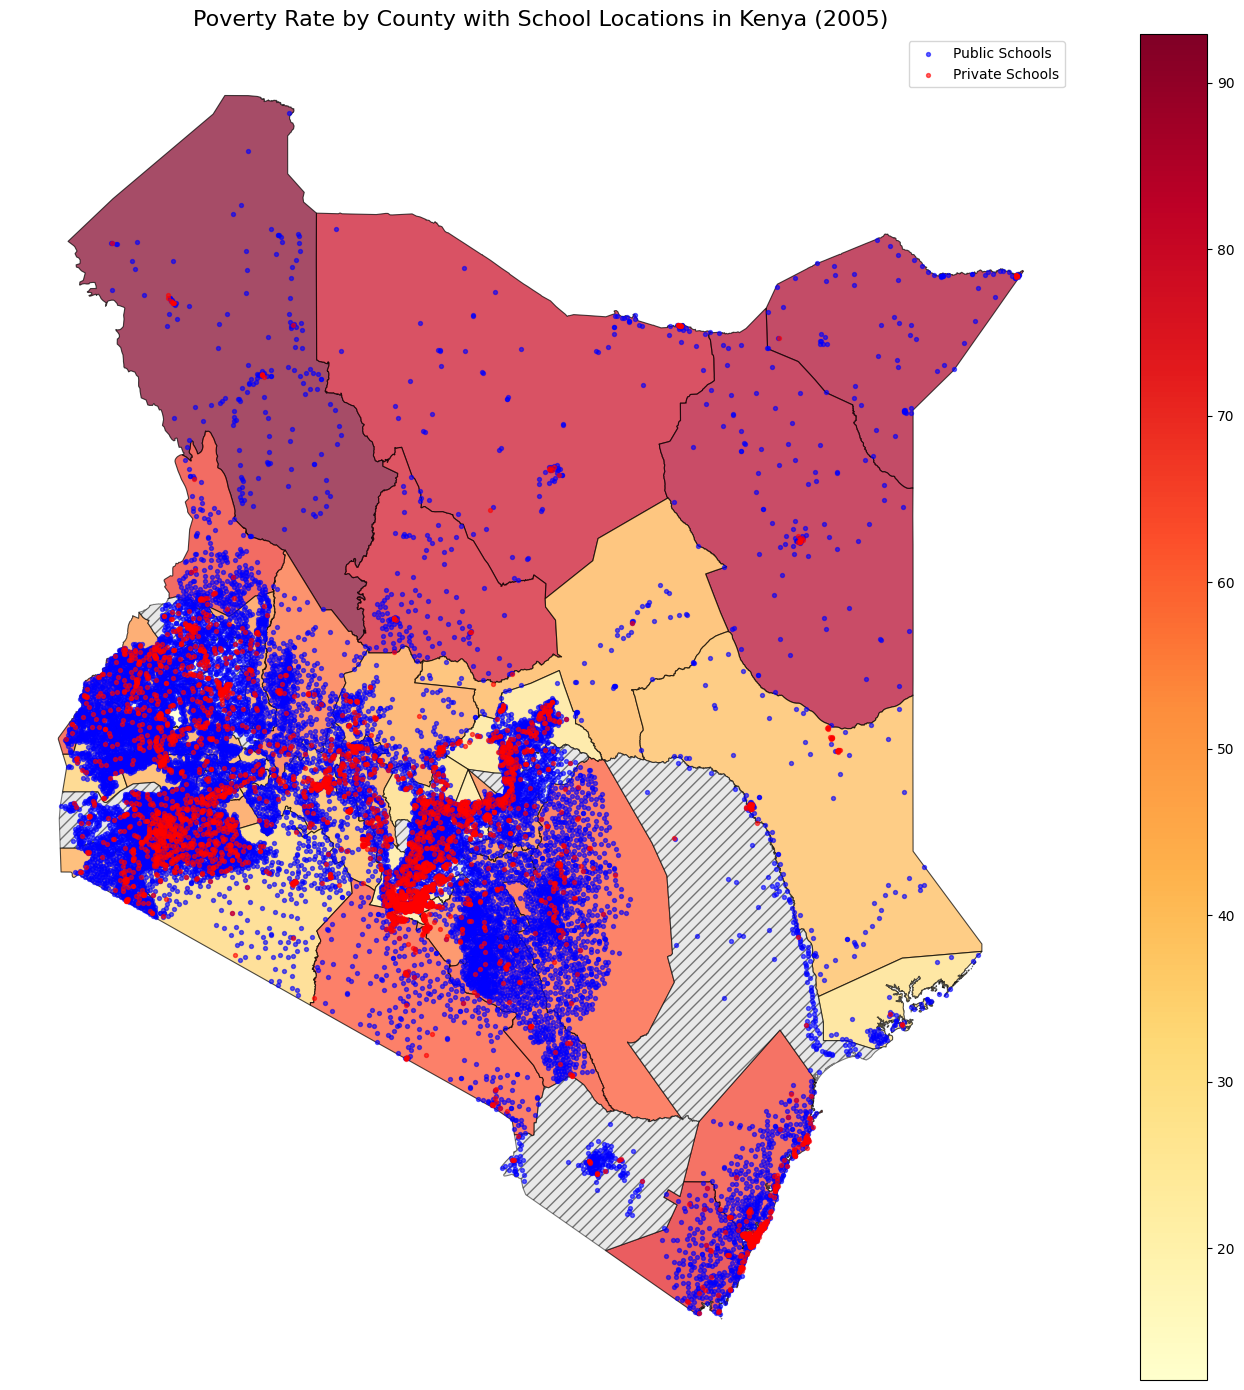


=== POVERTY-EDUCATION ANALYSIS SUMMARY ===
Counties with poverty data: 40/47
Average poverty rate: 51.0%
Highest poverty rate: 92.9% (TURKANA)
Lowest poverty rate: 12.1% (KAKAMEGA)


In [35]:
# 1. Load the county poverty rate data corrected with proper column name
poverty_file_url = "https://raw.githubusercontent.com/call493/MLFC/main/county_poverty_rates20056.csv"
poverty_df = pd.read_csv(poverty_file_url)

# Check columns again
print("Columns in poverty_df:", poverty_df.columns.tolist())
display(poverty_df.head())

# 2. Standardize county names using 'county' column (not 'County')
poverty_df['county'] = poverty_df['county'].str.strip().str.upper()

# 3. Merge with the 'merged' GeoDataFrame using 'county' column
merged_pov = merged.merge(
    poverty_df,
    left_on='shapeName',  # from geographic data
    right_on='county',    # from poverty data
    how='left'
)

# 4. Check merge results
print(f"\nSuccessfully merged {merged_pov.shape[0]} rows")
print(f"Non-null poverty rates: {merged_pov['poverty_rate__percentage_'].notna().sum()}")

# 5. Plot poverty rate map with school locations overlaid
fig, ax = plt.subplots(figsize=(14, 14))

# Plot counties colored by poverty rate
merged_pov.plot(
    column="poverty_rate__percentage_",  # using correct column name
    cmap="YlOrRd",                        # Yellow-Orange-Red colormap
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    alpha=0.7,
    missing_kwds={"color": "lightgray", "edgecolor": "black", "hatch": "///", "alpha": 0.5}
)

# Overlay school locations
public_schools.plot(
    ax=ax,
    color="blue",
    markersize=8,
    label="Public Schools",
    alpha=0.6
)
private_schools.plot(
    ax=ax,
    color="red",
    markersize=8,
    label="Private Schools",
    alpha=0.6
)

ax.set_title("Poverty Rate by County with School Locations in Kenya (2005)", fontsize=16)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()

# 6. Display summary statistics
print("\n=== POVERTY-EDUCATION ANALYSIS SUMMARY ===")
print(f"Counties with poverty data: {merged_pov['poverty_rate__percentage_'].notna().sum()}/{len(merged_pov)}")
print(f"Average poverty rate: {merged_pov['poverty_rate__percentage_'].mean():.1f}%")
print(f"Highest poverty rate: {merged_pov['poverty_rate__percentage_'].max():.1f}% ({merged_pov.loc[merged_pov['poverty_rate__percentage_'].idxmax(), 'shapeName']})")
print(f"Lowest poverty rate: {merged_pov['poverty_rate__percentage_'].min():.1f}% ({merged_pov.loc[merged_pov['poverty_rate__percentage_'].idxmin(), 'shapeName']})")